<a href="https://colab.research.google.com/github/shashwattrivedi/TimeSeriesTransformerLSTM/blob/master/TransformerTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
!git clone https://github.com/shashwattrivedi/Simple-TransformerEncoder-keras.git
!git clone https://github.com/shashwattrivedi/Attention_visualizer.git
!git clone https://github.com/shellshock1911/Sky-Cast-Capstone.git

Cloning into 'Simple-TransformerEncoder-keras'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 117 (delta 65), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (117/117), 596.37 KiB | 1.56 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Cloning into 'Attention_visualizer'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 44 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.
Cloning into 'Sky-Cast-Capstone'...
remote: Enumerating objects: 249, done.
remote: Total 249 (delta 0), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (249/249), 7.65 MiB | 9.08 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [0]:
!cp Simple-TransformerEncoder-keras/Transformer/* .
!cp Simple-TransformerEncoder-keras/Polarity_model/* .
!cp Attention_visualizer/attention_visualizer.py .

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import spacy

Using TensorFlow backend.


In [0]:
from TransformerEncoder import TransformerEncoder
from TrainablePositionalEmbeddings import TransformerPositionalEmbedding
from utility import *
from keras.layers import Input,Dense,Embedding,Add,Lambda,Flatten,Reshape,TimeDistributed,LSTM
from keras.models import Model
import pandas as pd
import numpy as np
from preprocess import *
from attention_visualizer import *

In [0]:
!cp -r Sky-Cast-Capstone/* .

In [0]:
# Compatibility between Python 2.7 and 3.x
from __future__ import unicode_literals, print_function, division
from io import open

# Wrangling
import glob # Files
import os # Files
import numpy as np # Arrays
import pandas as pd # DataFrames

# Preprocessing
from sklearn.preprocessing import StandardScaler # Centers mean at zero, applies unit variance
# Visualization
import matplotlib.pyplot as plt
from matplotlib import style
from statsmodels.tsa.stattools import adfuller
style.use('fivethirtyeight')

DATES = pd.date_range(start='2016-04-01', end='2017-03-01', freq='MS').to_pydatetime()

# Mapping of IATA airline codes to airline name
# Taken from http://www.iata.org/publications/Pages/code-search.aspx
AIRLINE_CODES = {
    'AS': 'Alaska_Airlines',
    'G4': 'Allegiant_Air',
    'AA': 'American_Airlines',
    'DL': 'Delta_Airlines',
    'F9': 'Frontier_Airlines',
    'MQ': 'Envoy_Air',
    'EV': 'ExpressJet_Airlines',
    'HA': 'Hawaiian_Airlines',
    'B6': 'JetBlue_Airways',
    'OO': 'SkyWest_Airlines',
    'WN': 'Southwest_Airlines',
    'NK': 'Spirit_Airlines',
    'UA': 'United_Airlines',
}

def load_data(airlines, category):
    """
    Takes a list of airlines and an industry metric and returns
    a N X 174 dataframe, where N rows represents the number of unique
    airline-airport combinations for which data exists and 174 columns
    represents the maximum number of months in the datasets
    
    @airlines: List of IATA airline codes (AA, DL, UA, etc.)
    @category: Industry metric to slice (Passengers, Flights, ASM, RPM)
    """
    
    rows = list() # Hold rows for data on each airline-airport combination
    index = list() # A combination (e.g. AA-DFW, DL-ATL, UA-ORD) serves as the row label
    
    # Monthly intervals between October 2002 to March 2017
    dates = [pd.datetime.strftime(date, '%Y-%m') for date in 
             pd.date_range(start='2002-10-01', end='2017-03-31', freq='M')]
    
    # Go into each airline directory
    for airline in airlines:
        # Make a list of all airline-airport csv files
        datasets = glob.glob('datasets/{}/*.csv'.format(AIRLINE_CODES[airline]))
        # Then load each dataset and slice the desired industry metric
        for dataset in datasets:
            data = pd.read_csv(dataset)
            series = data[category + '_Domestic']
            # Ensure that data for all 174 months can be fetched
            if len(data) == 174:
                # Make dictionary with dates as keys and metric quantities as values
                # Values for each column label (dates) now represent a single row 
                row = {date: count for date, count in zip(dates, series)}
                # Add to row list
                rows.append(row)
                # Label row with airline-airport combination
                index.append(os.path.splitext(os.path.split(dataset)[1])[0])
    
    # Convert rows, dates, and index into DataFrame            
    df = pd.DataFrame(data=rows, columns=dates, index=index)
    df.index.name = category
    return df

def remove_seasonality(time_series, lag):
    difference = list()
    for i in range(lag, len(time_series)):
        value = time_series[i] - time_series[i - lag]
        difference.append(value)
    time_series = pd.Series(difference)
    return time_series

def add_seasonality(history, pred, lag=1):
    return pred + history[-lag]

DATES = pd.date_range(start='2002-10-01', end='2017-03-01', freq='MS').to_pydatetime()

def test_stationarity(df, airline, airport, lag, deseason=False):
    
    """Takes a single pandas Series and produces evidence that can be used
    to analyze stationarity or lack thereof in the time series
    """
    
    time_series = df.loc[airline + '-' + airport].reset_index(drop=True)
    
    if deseason:
        time_series = remove_seasonality(time_series, lag)
        
    # Check for upward or downward sloping trends in the moving average.
    # Trends indicate non-stationarity which should be taken into account
    # when building ARIMA model.
    
    moving_average = time_series.rolling(window=lag).mean()
    moving_std = time_series.rolling(window=lag).std()
    title = "Rolling Mean & Standard Deviation"
   
    plt.figure(figsize=(20, 8))
    plt.plot(DATES, time_series, color='blue', label='Monthly {0}-{1} {2}'.format(airline, airport, df.index.name))
    plt.plot(DATES, moving_average, color='red', label='{} Month Moving Average'.format(lag))
    plt.plot(DATES, moving_std, color='black', label='{} Month Moving Std.'.format(lag))
    plt.xlabel("Year")
    plt.ylabel("Monthly {}".format(df.index.name))
    plt.legend(loc='best')
    plt.title(title, fontsize=20)
    plt.setp(plt.xticks()[1], fontsize=14)
    plt.savefig('trend_visual-{0}-{1}'.format(airline, airport))
    plt.show()
    
    # The greater the p-value in the test output, the stronger the
    # non-stationarity of the time series. Series with p-value less
    # than 0.05 can generally be considered at least weakly stationary
    
    print('Results of Dickey-Fuller Test:')
    test = adfuller(time_series, autolag='AIC')
    test_output = pd.Series(test[0:4], index=['Test Statistic', 'p-value',
                         '#Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        test_output['Critical Value {}'.format(key)] = value
    print(test_output)

def MAPE(y_test, preds):
    """Mean Absolute Percentage Error:
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    """
    mape_score = 100 * (np.sum(np.abs(y_test - preds) / y_test) / len(y_test))
    return round(mape_score, 3)

def fetch_sample(df, batch_size, output_seq_len, excluded=None, random_state=None):
    """
    Takes a list of airlines and an industry metric and returns
    a N X 174 dataframe, where N rows represents the number of unique
    airline-airport combinations for which data exists and 174 columns
    represents the maximum number of months in the datasets
    
    @df: DataFrame to sample random time series from (Passengers, Flights, ASM, RPM)
    @batch_size: How many time series to sample at a time
    @output_seq_len: How many months to reserve for prediction (training target)
    @random_state: Controls reproducible output
    """
    
    # During training, exclude samples that will later be used for testing (to prevent overfitting)
    if excluded:
        excluded = df.index.isin(excluded)
        df = df[~excluded]
    
    # Train on all months prior to the months reserved for prediction
    input_seq_len = df.shape[1] - output_seq_len
    
    # Sample n random rows from the given dataframe
    sample = df.sample(n=batch_size, replace=False, axis=0, random_state=random_state)
    # Log transform values in batch
    log_sample = np.log(sample)
    
    # Standardize numerical values in batch to zero mean and unit variance
    scaler = StandardScaler()
    scaled_sample = scaler.fit_transform(log_sample.transpose())
    
    # Separate past values (training sequence input) from future values (target sequence output)
    sample_X, sample_y = scaled_sample[:input_seq_len], scaled_sample[-output_seq_len:]
    
    # Reshape dimensions to sequence_length X batch_size X 1 (univariate time series)
    sample_X = sample_X.reshape((input_seq_len, batch_size, 1))
    sample_y = sample_y.reshape((output_seq_len, batch_size, 1))
    
    return scaler, sample_X, sample_y

def load_test_series(df, airline, airport, output_seq_len):
    """
    Loads a specific airline-airport time series for testing, applies transformations,
    and divides it into test features and targets
    
    @df: DataFrame to draw specific time series from (Passengers, Flights, ASM, RPM)
    @airline: IATA airline code (AA, DL, UA, etc.)
    @airport: IATA airport code (ATL, DFW, ORD, etc.)
    @output_seq_len: How many months to reserve for prediction (test target)
    """
    # Train on all months prior to the months reserved for prediction
    
    input_seq_len = df.shape[1] - output_seq_len
    
    # Load specific time series given by airline-airport parameters
    series = df.loc[airline + '-' + airport]
    # Log transform series
    log_series = np.log(series)
    
    # Standardize series to zero mean and unit variance
    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(log_series.values.reshape(-1, 1))
    scaled_series = scaled_series.reshape(-1)
    
    # Divide series into training 
    X_test = scaled_series[:input_seq_len]
    y_test = scaled_series[-output_seq_len:]
    
    # Return scaler to perform inverse transformation on data
    return scaler, X_test, y_test
  
  
def load_test_series_sum(df, output_seq_len):
    """
    Loads a specific airline-airport time series for testing, applies transformations,
    and divides it into test features and targets
    
    @df: DataFrame to draw specific time series from (Passengers, Flights, ASM, RPM)
    @airline: IATA airline code (AA, DL, UA, etc.)
    @airport: IATA airport code (ATL, DFW, ORD, etc.)
    @output_seq_len: How many months to reserve for prediction (test target)
    """
    # Train on all months prior to the months reserved for prediction
    
    input_seq_len = df.shape[1] - output_seq_len
    
    # Load specific time series given by airline-airport parameters
    series = df.loc[0]
    # Log transform series
    log_series = np.log(series)
    
    # Standardize series to zero mean and unit variance
    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(log_series.values.reshape(-1, 1))
    scaled_series = scaled_series.reshape(-1)
    
    # Divide series into training 
    X_test = scaled_series[:input_seq_len]
    y_test = scaled_series[-output_seq_len:]
    
    # Return scaler to perform inverse transformation on data
    return scaler, X_test, y_test


In [0]:
DATES = pd.date_range(start='2016-04-01', end='2017-03-01', freq='MS').to_pydatetime()

def test_batch(ts_model,df, batch_size, output_seq_len, random_state=None, viz=False):
    """
    Tests session model on a batch of random time series drawn from one of the metrics DataFrames.
    All passed parameters should be same as those used during training.
    
    @df: DataFrame to sample random time series from (Passengers, Flights, ASM, RPM)
    @batch_size: How many time series to sample at a time
    @output_seq_len: How many months to set aside for prediction (training target)
    @random_state: Controls reproducible output
    @viz: Whether to produce visual comparision or simply return test loss
    """
    scaler, X_test, y_test = fetch_sample(df=df, output_seq_len=output_seq_len, 
                              batch_size=batch_size, random_state=random_state)
#     feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
#     feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
#     test_loss = sess.run([loss], feed_dict)
#     print(X_test.shape)//
    X_test1 = np.copy(X_test)
    y_test1 = np.copy(y_test)
    X_test1 = np.transpose(X_test1,(1,0,2))
    y_test1 = np.transpose(y_test1,(1,0,2))
#     print(X_test.shape)
#     print(X_test1.shape)
    test_loss = ts_model.evaluate(X_test1,y_test1)
    
    if viz:
#         preds = np.array(sess.run([reshaped_outputs], feed_dict)[0])
        preds = np.array(ts_model.predict(X_test1))
#         print(X_test.shape)
        real_X_test = X_test.reshape(-1, 3)
        real_X_test = scaler.inverse_transform(real_X_test)
#         print(real_X_test)
#         print(y_test.shape)
#         print(preds.shape)
        preds = np.transpose(preds,(1,0,2))
#         print(preds.shape)
        real_X_test = np.exp(scaler.inverse_transform(X_test.reshape(-1, 3)))
        real_y_test = np.exp(scaler.inverse_transform(y_test.reshape(-1, 3)))
        real_preds = np.exp(scaler.inverse_transform(preds.reshape(-1, 3)))

        label_0 = "Past (training) Values"
        label_1 = "Future (target) Values"
        label_2 = "Future (predicted) values"

        for i in range(X_test.shape[1]):
            MAPE_score = utils.MAPE(real_y_test[:,i], real_preds[:,i])
            plt.figure(figsize=(20, 8))
            plt.grid(True)
            plt.plot(range(len(real_X_test)), real_X_test[:,i], "o--b", label=label_0, ms=10)
            plt.plot(range(len(real_X_test), len(real_X_test) + len(real_y_test)), real_y_test[:,i], '*--', c='#ee7600', label=label_1, ms=10)
            plt.plot(range(len(real_X_test), len(real_X_test) + len(real_preds)), real_preds[:,i], '^--', c='#0d7629', label=label_2, ms=10)
            plt.xlabel("Month Number")
            plt.ylabel("Monthly {}".format(df.index.name))
            plt.legend(loc='best', fontsize=20)
            if i == 0:  
                plt.title("Seq2Seq RNN // Sideways - Major Spike (MAPE = {})%".format(MAPE_score), fontsize=20)
            elif i == 1:
                plt.title("Seq2Seq RNN // Downtrend - Sideways (MAPE = {})%".format(MAPE_score), fontsize=20)
            else:
                plt.title("Seq2Seq RNN // Sideways - Minor Spike (MAPE = {})%".format(MAPE_score), fontsize=20)
            plt.show()
            
    else:
        return test_loss
        
def test_series(ts_model, df, airline, airport, output_seq_len):
    """
    Tests session model on a specific airline-airport series, visually comparing
    actual values to forecasted values and displaying MAPE score. DataFrame
    and output_seq_len should be same as those used during training.
    
    @df: DataFrame to draw specific time series from (Passengers, Flights, ASM, RPM)
    @airline: IATA airline code (AA, DL, UA, etc.)
    @airport: IATA airport code (ATL, DFW, ORD, etc.)
    @output_seq_len: How many months to reserve for prediction (test targets)
    """
    
    scaler, X_test, y_test = load_test_series(
        df=df, airline=airline, airport=airport, output_seq_len=output_seq_len)
    X_test = X_test.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
#     print(X_test.shape)
    X_test1 = np.copy(X_test)
    y_test1 = np.copy(y_test)
    X_test1 = np.transpose(X_test1,(1,0,2))
    y_test1 = np.transpose(y_test1,(1,0,2))
    
#     feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
#     preds = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    
    preds = ts_model.predict(X_test1)
    preds = np.transpose(preds,(1,0,2))
    real_X_test = np.exp(scaler.inverse_transform(X_test))
    real_y_test = np.exp(scaler.inverse_transform(y_test))
    print(real_y_test.shape)
    real_preds = np.exp(scaler.inverse_transform(preds))
    print(real_preds.shape)
    MAPE_score = utils.MAPE(real_y_test, real_preds)
    
    label_0 = "Future (target) Values"
    label_1 = "Future (predicted) values"
    title = "Seq2Seq RNN // {0}-{1}: Monthly {2} (MAPE = {3}%)".format(airline, airport, df.index.name, MAPE_score)
    
    plt.figure(figsize=(20, 8))
    plt.plot(DATES, real_y_test[:,0], '*--', c='#ee7600', label=label_0, ms=20)
    plt.plot(DATES, real_preds[:,0], '^--', c='#0d7629', label=label_1, ms=20)
    plt.xlabel("Date (YYYY-MM)")
    plt.ylabel("Monthly {}".format(df.index.name))
    plt.legend(loc='best', fontsize=20)
    plt.title(title, fontsize=20)
    plt.setp(plt.xticks()[1], rotation=45, fontsize=14)
    plt.savefig('test_series-{}-{}'.format(airline, airport))
    plt.show()
    
def test_series_MAPE(df, airline, airport, output_seq_len):
    """
    Tests session model on a specific airline-airport series, visually comparing
    actual values to forecasted values and displaying MAPE score. DataFrame
    and output_seq_len should be same as those used during training.
    
    @df: DataFrame to draw specific time series from (Passengers, Flights, ASM, RPM)
    @airline: IATA airline code (AA, DL, UA, etc.)
    @airport: IATA airport code (ATL, DFW, ORD, etc.)
    @output_seq_len: How many months to reserve for prediction (test targets)
    """
    
    scaler, X_test, y_test = load_test_series(
        df=df, airline=airline, airport=airport, output_seq_len=output_seq_len)
    X_test = X_test.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
#     print(X_test.shape)
    X_test1 = np.copy(X_test)
    y_test1 = np.copy(y_test)
    X_test1 = np.transpose(X_test1,(1,0,2))
    y_test1 = np.transpose(y_test1,(1,0,2))
    
#     feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
#     preds = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    
    preds = ts_model.predict(X_test1)
    preds = np.transpose(preds,(1,0,2))
    real_X_test = np.exp(scaler.inverse_transform(X_test))
    real_y_test = np.exp(scaler.inverse_transform(y_test))
    print(real_y_test.shape)
    real_preds = np.exp(scaler.inverse_transform(preds))
    print(real_preds.shape)
    MAPE_score = utils.MAPE(real_y_test, real_preds)
    
    return MAPE_score
    
def test_series_sum(df, airline, airport, output_seq_len):
  """
  Tests session model on a specific airline-airport series, visually comparing
  actual values to forecasted values and displaying MAPE score. DataFrame
  and output_seq_len should be same as those used during training.

  @df: DataFrame to draw specific time series from (Passengers, Flights, ASM, RPM)
  @airline: IATA airline code (AA, DL, UA, etc.)
  @airport: IATA airport code (ATL, DFW, ORD, etc.)
  @output_seq_len: How many months to reserve for prediction (test targets)
  """

  scaler, X_test, y_test = load_test_series_sum(
      df=df, output_seq_len=output_seq_len)
  X_test = X_test.reshape(-1, 1, 1)
  y_test = y_test.reshape(-1, 1, 1)
#     print(X_test.shape)
  X_test1 = np.copy(X_test)
  y_test1 = np.copy(y_test)
  X_test1 = np.transpose(X_test1,(1,0,2))
  y_test1 = np.transpose(y_test1,(1,0,2))

#     feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
#     preds = np.array(sess.run([reshaped_outputs], feed_dict)[0])

  preds = ts_model.predict(X_test1)
  preds = np.transpose(preds,(1,0,2))
  real_X_test = np.exp(scaler.inverse_transform(X_test))
  real_y_test = np.exp(scaler.inverse_transform(y_test))
  print(real_y_test.shape)
  real_preds = np.exp(scaler.inverse_transform(preds))
  print(real_preds.shape)
  MAPE_score = utils.MAPE(real_y_test, real_preds)

  label_0 = "Future (target) Values"
  label_1 = "Future (predicted) values"
  title = "Seq2Seq RNN // {0}-{1}: Monthly {2} (MAPE = {3}%)".format(airline, airport, df.index.name, MAPE_score)

  plt.figure(figsize=(20, 8))
  plt.plot(DATES, real_y_test[:,0], '*--', c='#ee7600', label=label_0, ms=20)
  plt.plot(DATES, real_preds[:,0], '^--', c='#0d7629', label=label_1, ms=20)
  plt.xlabel("Date (YYYY-MM)")
  plt.ylabel("Monthly {}".format(df.index.name))
  plt.legend(loc='best', fontsize=20)
  plt.title(title, fontsize=20)
  plt.setp(plt.xticks()[1], rotation=45, fontsize=14)
  plt.savefig('test_series-{}-{}'.format(airline, airport))
  plt.show()

In [0]:
# Data shape parameters
batch_size = 3 # How many time series to train on before updating model's weight parameters
output_seq_len = 12 # How many months to predict into the future
input_seq_len = period_len - output_seq_len # How many months to train on in the past

# Internal neural network parameters
input_dim = output_dim = 1 # Univariate time series (predicting future values based on stream of historical values)
hidden_dim = 100  # Number of neurons in each recurrent unit 
num_layers = 2  # Number of stacked recurrent cells (number of recurrent layers)

# Optimizer parameters
learning_rate = 0.005  # Small lr helps not to diverge during training. 
epochs = 300  # How many times we perform a training step (how many times we show a batch)
lr_decay = 0.9  # default: 0.9 . Simulated annealing.
momentum = 0.2  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - reduces overfitting

# Declare which airline-airport time series will be used for testing
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
# Exclude them from training phase
excluded = map('-'.join, airline_airports)
# Allow fetching of same three samples during validation
random_state = 42

In [0]:
# Compatibility between Python 2.7 and 3.x
from __future__ import unicode_literals, print_function, division
from io import open
# Wrangling
import glob # Files
import os # Files
import numpy as np # Arrays
import pandas as pd # DataFrames
# Preprocessing
from sklearn.preprocessing import StandardScaler # Centers mean at zero, applies unit variance
# Visualization
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
# Modeling
import tensorflow as tf # Deep Learning
# Custom utility functions shared across notebooks
# import utils

#**Hyper-parameters**

In [0]:
positional_ff_dim   = 128

# Reading data and Preprocess

In [0]:
period_len = 174 # Maximum number of months for which data exists
airlines = ['AA', 'DL', 'UA'] # Airlines of interest in forecasting
passengers_df = load_data(airlines, category='Passengers') # Monthly passenger counts
flights_df = load_data(airlines, category='Flights') # Monthly flight counts
asm_df = load_data(airlines, category='ASM') # Monthly available seat miles
rpm_df = load_data(airlines, category='RPM') # Monthly revenue passenger miles

# Fetch complete datasets only / ensure that 174 months of data exist for dataframes in each category
assert passengers_df.shape[1] == flights_df.shape[1] == asm_df.shape[1] == rpm_df.shape[1] == period_len

# Model

In [0]:
def time_series_model_LSTM_Transformer():
    
    encoder_inputs = Input((input_seq_len,input_dim,),dtype='float32',name='Encoder_input')
#     encoder = [LSTM(hidden_dim,return_state=True,return_sequences=True,name='Encoder'+str(i)) for i in range(num_layers)]
    
    positional_embedding_layer    = TransformerPositionalEmbedding(name='Positional_embedding')
    next_step_input               = positional_embedding_layer(encoder_inputs)
    
    next_step_input,attention =TransformerEncoder(hidden_dim,
                                                             2,
                                                             hidden_dim,
                                                             hidden_dim,
                                                             positional_ff_dim,
                                                             dropout_rate= 0.1,
                                                             name= 'Transformer')(next_step_input)
    next_step_input,attention =TransformerEncoder(hidden_dim,
                                                         2,
                                                         hidden_dim,
                                                         hidden_dim,
                                                         positional_ff_dim,
                                                         dropout_rate= 0.1,
                                                         name= 'Transformer1')(next_step_input)
    
    state_h = Lambda(lambda x : x[:,0, :] )(next_step_input)
    state_c = Lambda(lambda x : x[:,1, :] )(next_step_input)
    
#     print(state_h)
    decoder_inputs = Input(tensor=encoder_inputs[:,-(output_seq_len):,:])
    decoder = LSTM(hidden_dim,return_sequences=True,return_state=True,name='Decoder')
    predicted_values,_,_ = decoder(decoder_inputs,initial_state = [state_h,state_c])
#     print(predicted_values)
#     predicted_values = Lambda(lambda x : x[:,:output_seq_len, :] )(next_step_input)
    reshaped_outputs = TimeDistributed(Dense(output_dim))(predicted_values)
    
    return Model(inputs= [encoder_inputs,decoder_inputs],output=[reshaped_outputs])
    

In [166]:
ts_model = time_series_model_LSTM_Transformer()
ts_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      (None, 162, 1)       0                                            
__________________________________________________________________________________________________
Positional_embedding (Transform (None, 162, 1)       162         Encoder_input[0][0]              
__________________________________________________________________________________________________
Transformer_QueryLayer (TimeDis (None, 162, 200)     200         Positional_embedding[0][0]       
__________________________________________________________________________________________________
Transformer_KeyLayer (TimeDistr (None, 162, 200)     200         Positional_embedding[0][0]       
__________________________________________________________________________________________________
reshape_41

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [0]:
def train_samples(df, output_seq_len, excluded):
    _, X_train, y_train = utils.fetch_sample(df = df, batch_size = len(df), output_seq_len = output_seq_len, excluded = excluded)
    return X_train, y_train

In [0]:
import tensorflow
class NBatchLogger(tensorflow.keras.callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()

In [0]:
printatNepoch = NBatchLogger(10)

#Passengers Forecasting
##Passengers training

In [202]:
ts_model = time_series_model_LSTM_Transformer()
ts_model.compile('nadam',
                loss='mean_squared_error')
X_train, y_train = train_samples(df = passengers_df, output_seq_len=output_seq_len, excluded= excluded)
X_train = np.transpose(X_train,(1,0,2))
y_train = np.transpose(y_train,(1,0,2))

printatNepoch = NBatchLogger(20)
ts_model.fit(X_train,y_train,epochs = 200,batch_size = 40,verbose=0,callbacks=[printatNepoch] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


step: 20/None ...  - loss: 0.6375
step: 40/None ...  - loss: 0.2649
step: 60/None ...  - loss: 0.2205
step: 80/None ...  - loss: 0.1956
step: 100/None ...  - loss: 0.1826
step: 120/None ...  - loss: 0.1696
step: 140/None ...  - loss: 0.1540
step: 160/None ...  - loss: 0.1264
step: 180/None ...  - loss: 0.1226
step: 200/None ...  - loss: 0.1018
step: 220/None ...  - loss: 0.0921
step: 240/None ...  - loss: 0.0778
step: 260/None ...  - loss: 0.0649
step: 280/None ...  - loss: 0.0735
step: 300/None ...  - loss: 0.0568
step: 320/None ...  - loss: 0.0534
step: 340/None ...  - loss: 0.0474
step: 360/None ...  - loss: 0.0443
step: 380/None ...  - loss: 0.0447
step: 400/None ...  - loss: 0.0401


3/3 [==============================] - 16s 5s/step
(12, 3, 1)
(3, 12, 1)
(12, 3, 1)


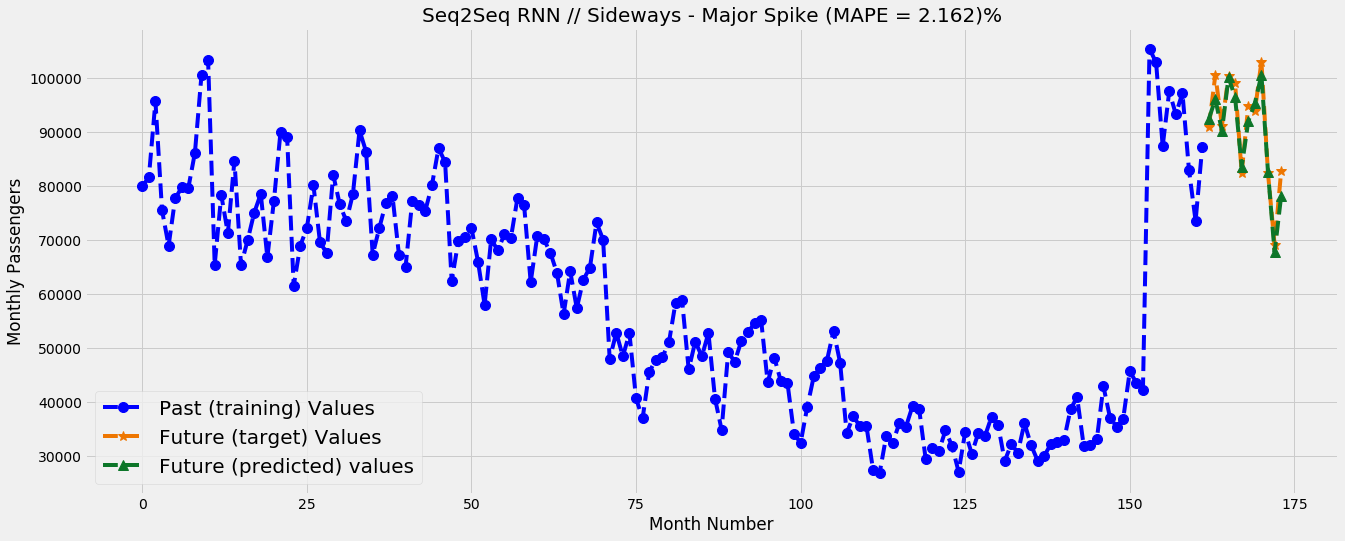

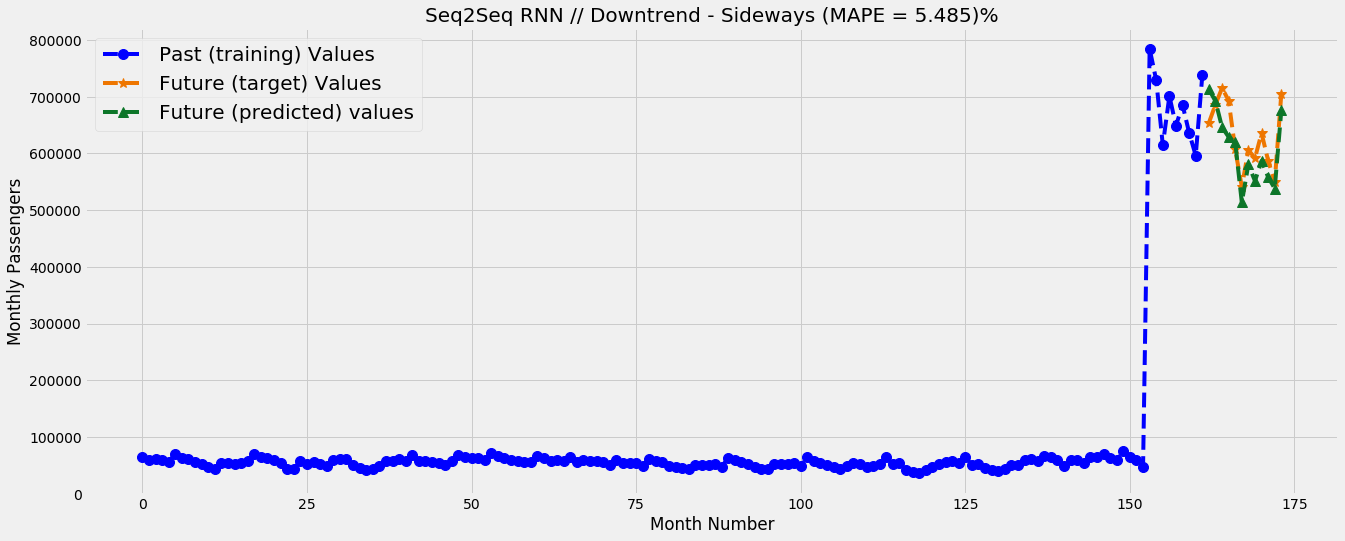

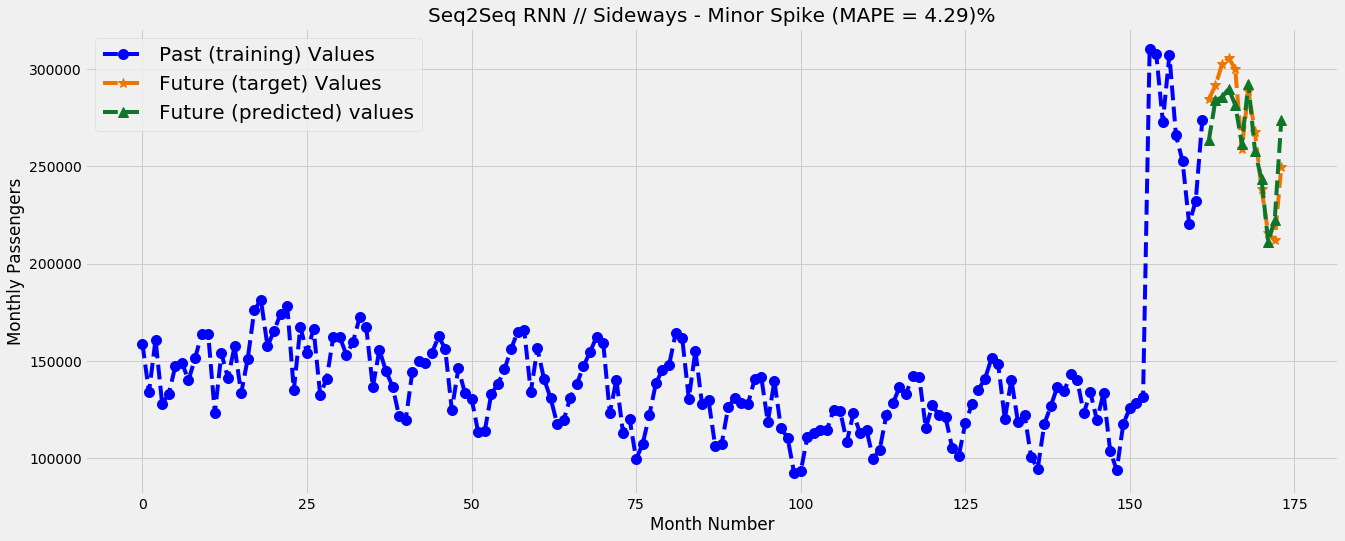

In [171]:
test_batch(df=passengers_df, batch_size=batch_size, output_seq_len=output_seq_len, random_state=21, viz=True)

##Forecasting passengers for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)

(12, 1, 1)
(12, 1, 1)


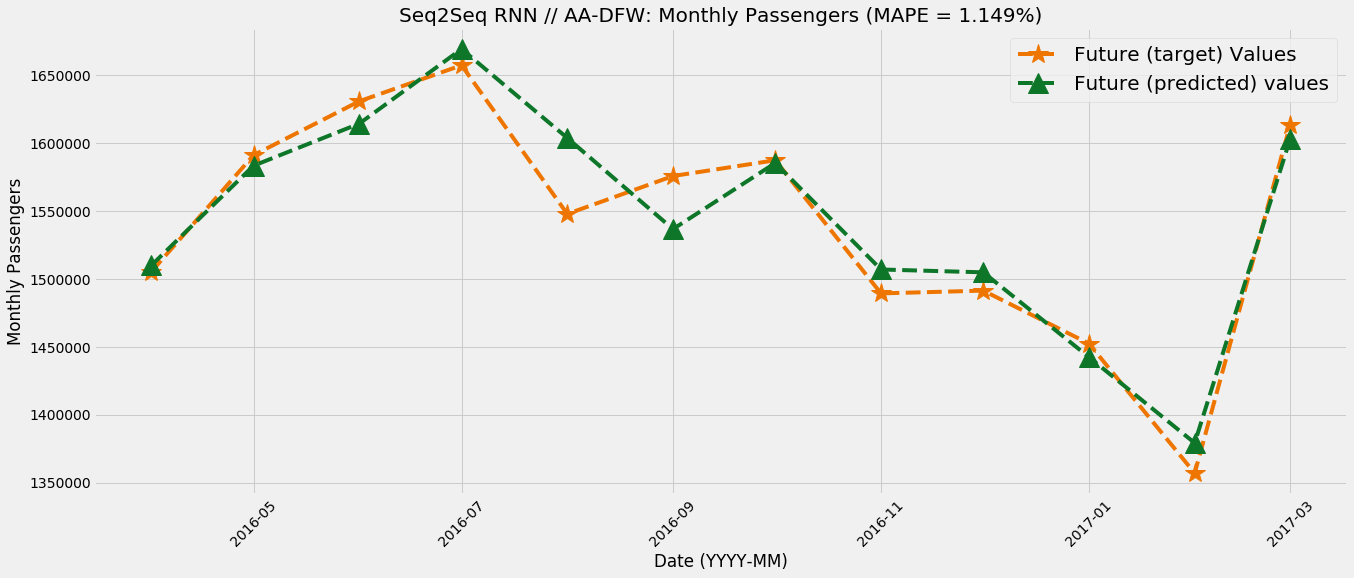

(12, 1, 1)
(12, 1, 1)


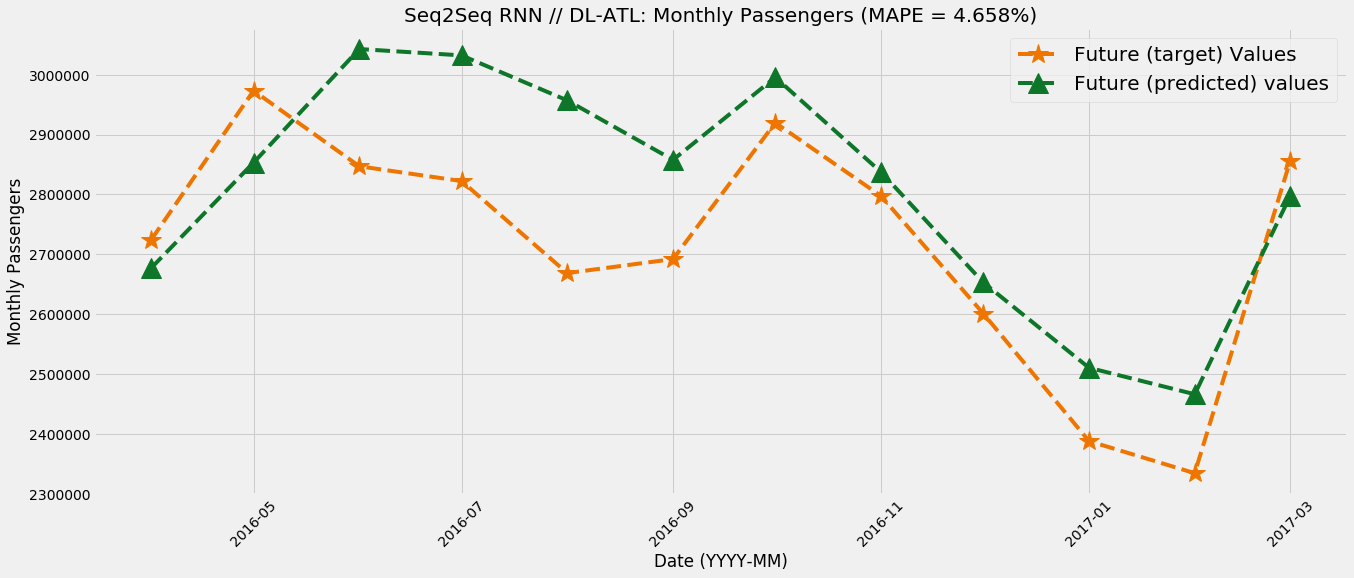

(12, 1, 1)
(12, 1, 1)


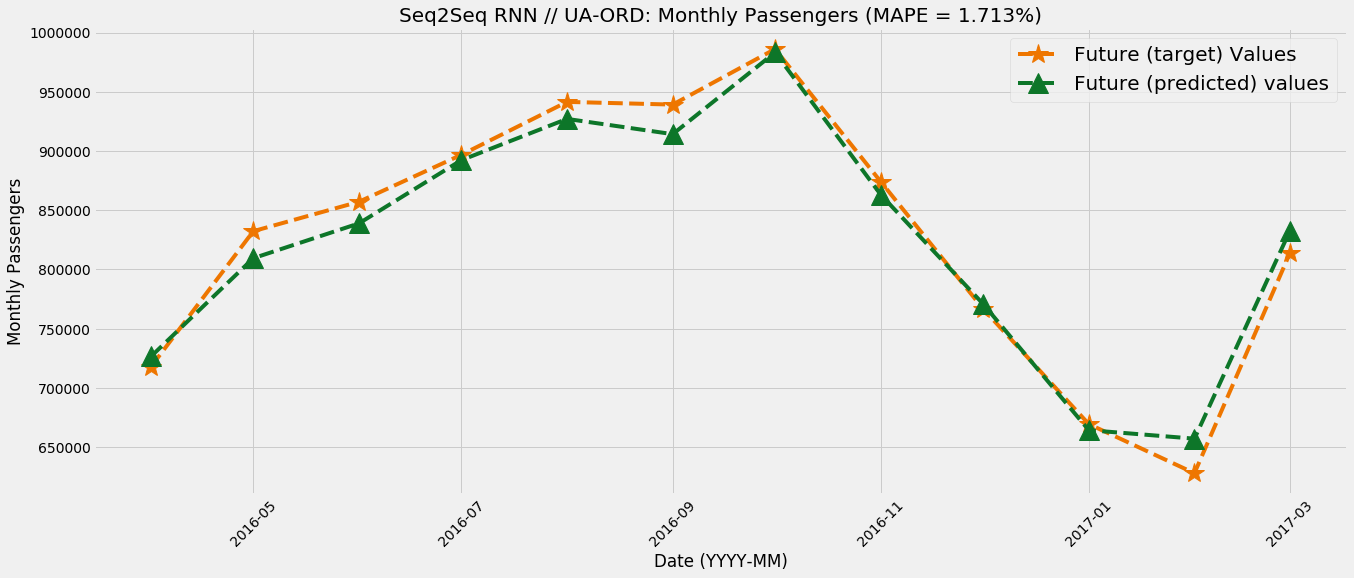

In [204]:
# Display passengers forecasts and MAPE scores for three key combinationss
for combo in airline_airports:
    airline, airport = combo
    test_series(ts_model=ts_model,df=passengers_df, airline=airline, airport=airport, output_seq_len=output_seq_len)

#Flights Forecasting
## Flights training

In [177]:
ts_model = time_series_model_LSTM_Transformer()
ts_model.compile('nadam',
                loss='mean_squared_error')
X_train, y_train = train_samples(df = flights_df, output_seq_len=output_seq_len, excluded= excluded)
X_train = np.transpose(X_train,(1,0,2))
y_train = np.transpose(y_train,(1,0,2))

printatNepoch = NBatchLogger(50)
ts_model.fit(X_train,y_train,epochs = 250,batch_size = 40,verbose=0,callbacks=[printatNepoch] )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


step: 50/None ...  - loss: 0.3810
step: 100/None ...  - loss: 0.1749
step: 150/None ...  - loss: 0.1368
step: 200/None ...  - loss: 0.1078
step: 250/None ...  - loss: 0.0928
step: 300/None ...  - loss: 0.0759
step: 350/None ...  - loss: 0.0680
step: 400/None ...  - loss: 0.0599
step: 450/None ...  - loss: 0.0546
step: 500/None ...  - loss: 0.0460


##Forecasting flights for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)¶

(12, 1, 1)
(12, 1, 1)


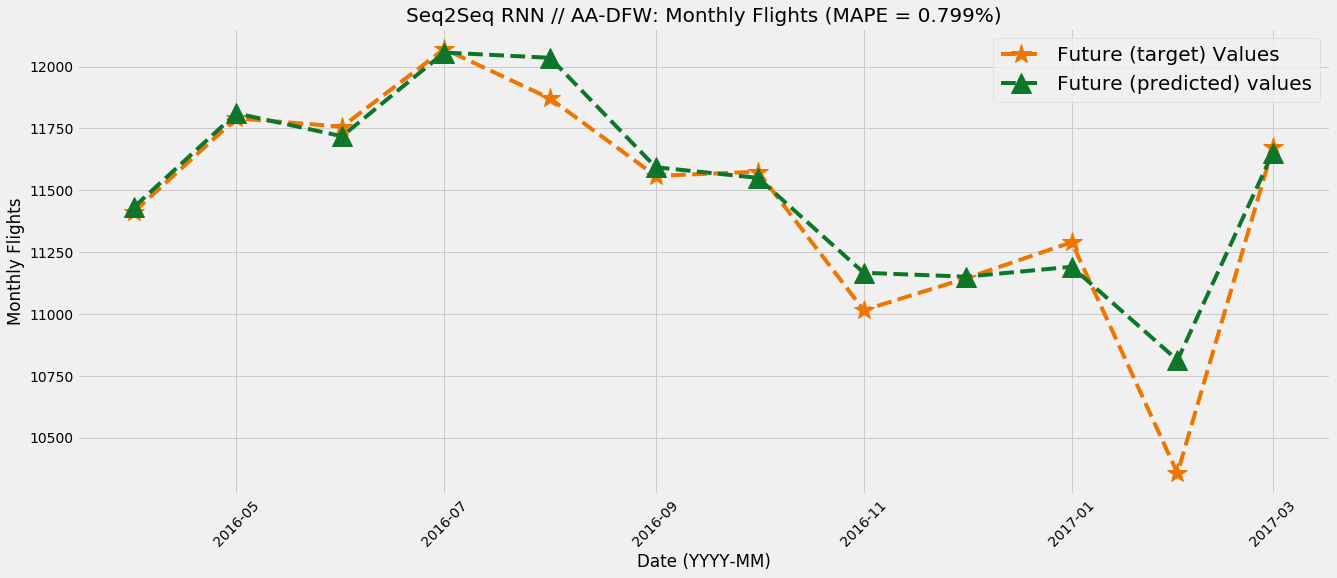

(12, 1, 1)
(12, 1, 1)


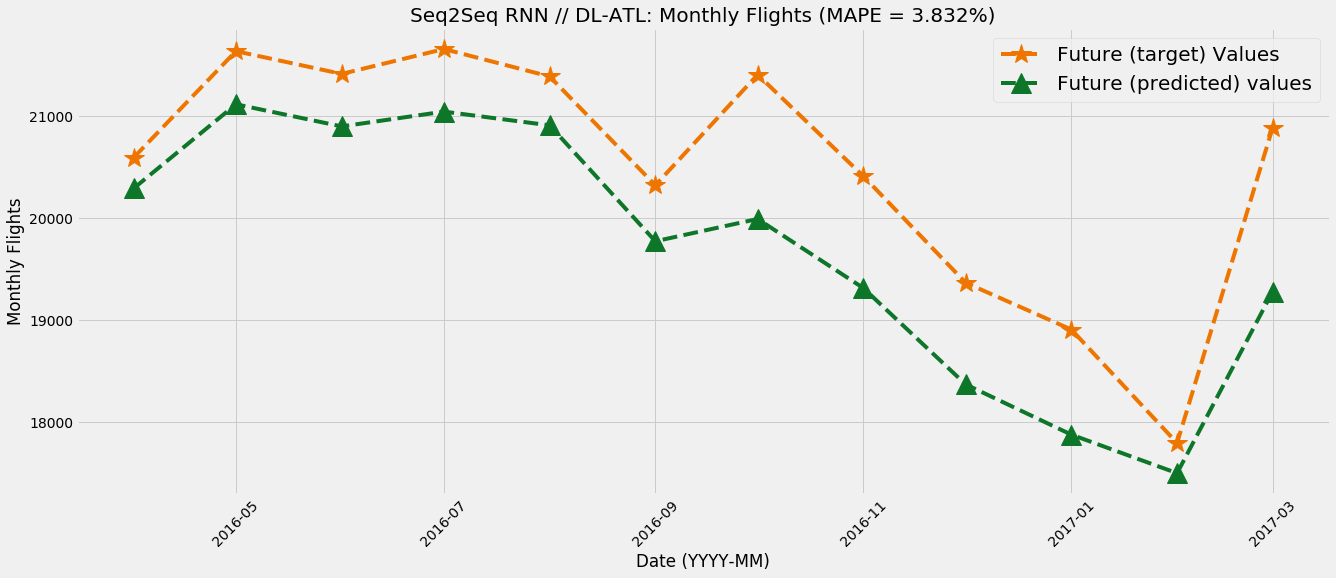

(12, 1, 1)
(12, 1, 1)


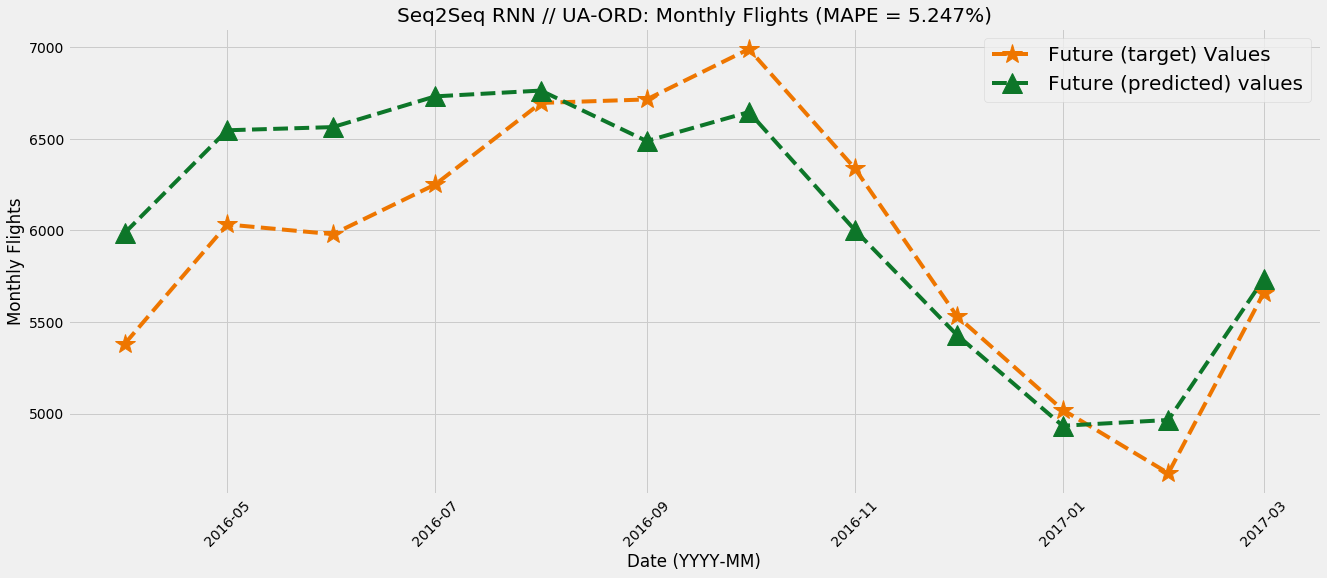

In [178]:
# Display flights forecasts and MAPE scores for three key combinations
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
for combo in airline_airports:
    airline, airport = combo
    test_series(df=flights_df, airline=airline, airport=airport, output_seq_len=output_seq_len)

#Available Seat Miles (ASM) Forecasting
##ASM training

In [180]:
ts_model = time_series_model_LSTM_Transformer()
ts_model.compile('nadam',
                loss='mean_squared_error')
X_train, y_train = train_samples(df = asm_df, output_seq_len=output_seq_len, excluded= excluded)
X_train = np.transpose(X_train,(1,0,2))
y_train = np.transpose(y_train,(1,0,2))

printatNepoch = NBatchLogger(50)
ts_model.fit(X_train,y_train,epochs = 250,batch_size = 40,verbose=0,callbacks=[printatNepoch] )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


step: 50/None ...  - loss: 0.3822
step: 100/None ...  - loss: 0.1702
step: 150/None ...  - loss: 0.1296
step: 200/None ...  - loss: 0.0985
step: 250/None ...  - loss: 0.0799
step: 300/None ...  - loss: 0.0630
step: 350/None ...  - loss: 0.0525
step: 400/None ...  - loss: 0.0477
step: 450/None ...  - loss: 0.0434
step: 500/None ...  - loss: 0.0349


##Forecasting ASM for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)

(12, 1, 1)
(12, 1, 1)


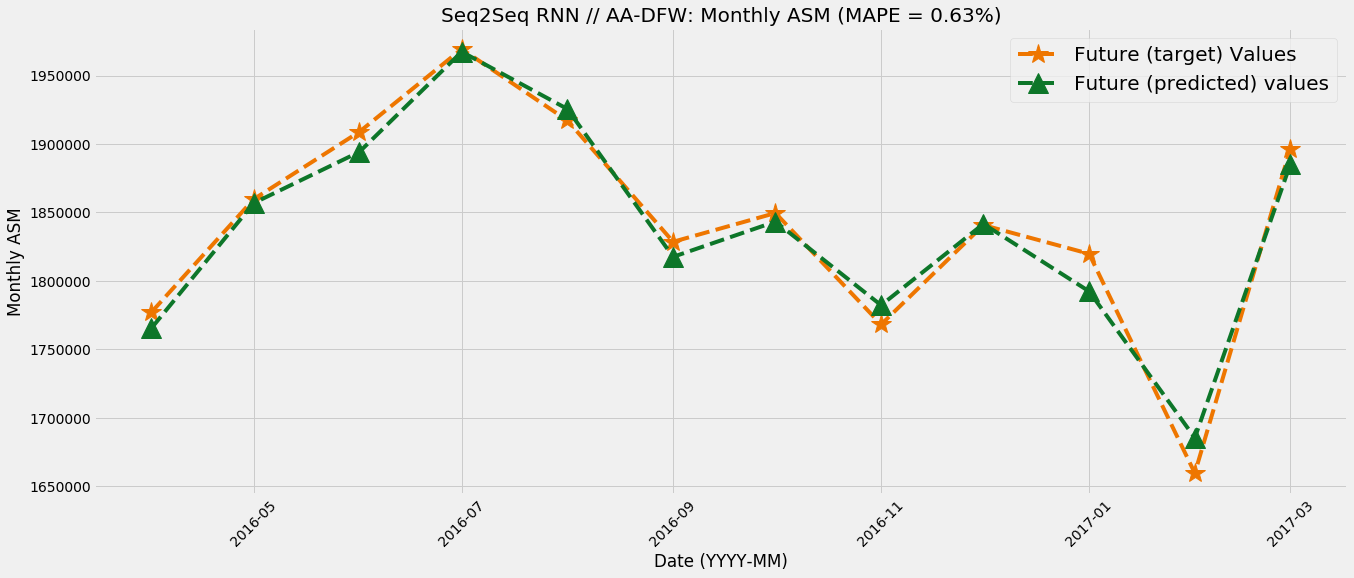

(12, 1, 1)
(12, 1, 1)


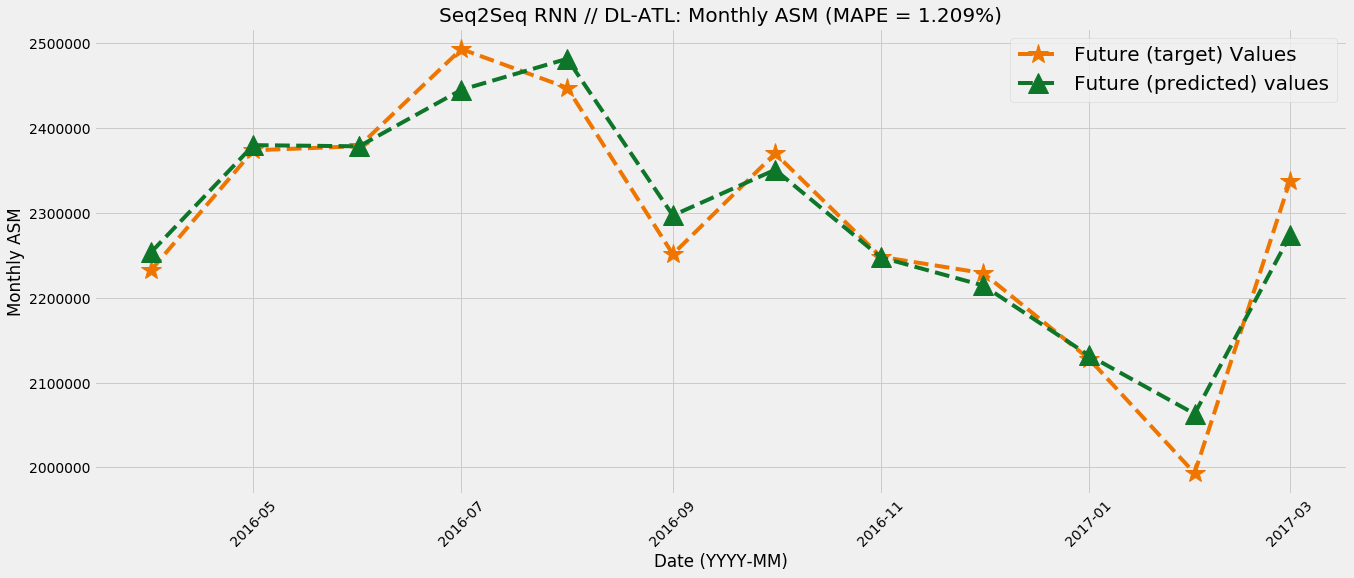

(12, 1, 1)
(12, 1, 1)


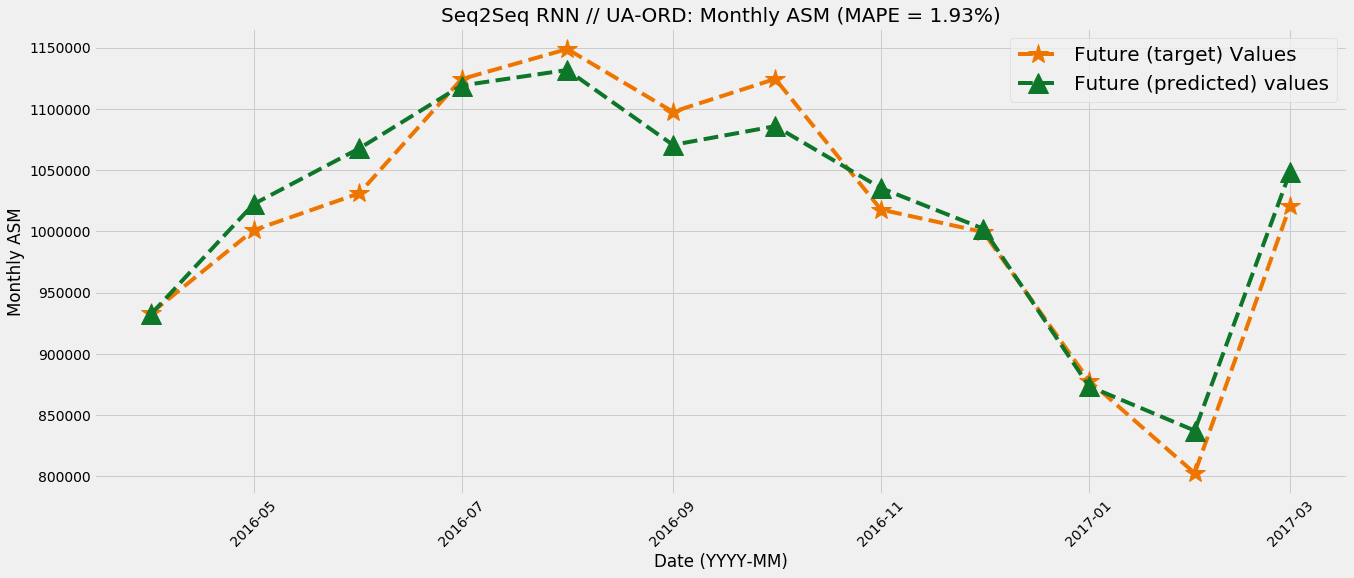

In [181]:
# Display ASM forecasts and MAPE scores for three key combinations
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
for combo in airline_airports:
    airline, airport = combo
    test_series(ts_model = ts_model,df=asm_df, airline=airline, airport=airport, output_seq_len=output_seq_len)

#Revenue Passenger Miles (RPM) Forecasting
##RPM training

In [182]:
ts_model = time_series_model_LSTM_Transformer()
ts_model.compile('nadam',
                loss='mean_squared_error')
X_train, y_train = train_samples(df = rpm_df, output_seq_len=output_seq_len, excluded= excluded)
X_train = np.transpose(X_train,(1,0,2))
y_train = np.transpose(y_train,(1,0,2))

printatNepoch = NBatchLogger(50)
ts_model.fit(X_train,y_train,epochs = 250,batch_size = 40,verbose=0,callbacks=[printatNepoch] )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


step: 50/None ...  - loss: 0.4118
step: 100/None ...  - loss: 0.1993
step: 150/None ...  - loss: 0.1225
step: 200/None ...  - loss: 0.0866
step: 250/None ...  - loss: 0.0666
step: 300/None ...  - loss: 0.0610
step: 350/None ...  - loss: 0.0525
step: 400/None ...  - loss: 0.0460
step: 450/None ...  - loss: 0.0353
step: 500/None ...  - loss: 0.0364


##Forecasting RPM for airport-airline combinations of interest (AA-DFW, DL-ATL, UA-ORD)

(12, 1, 1)
(12, 1, 1)


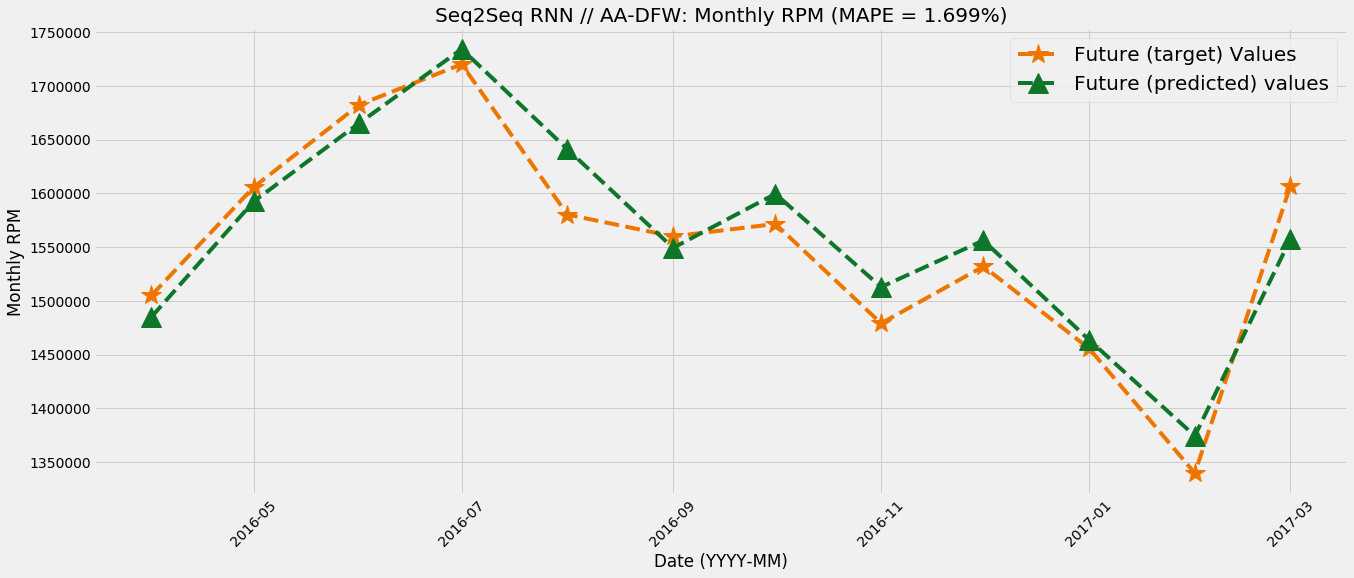

(12, 1, 1)
(12, 1, 1)


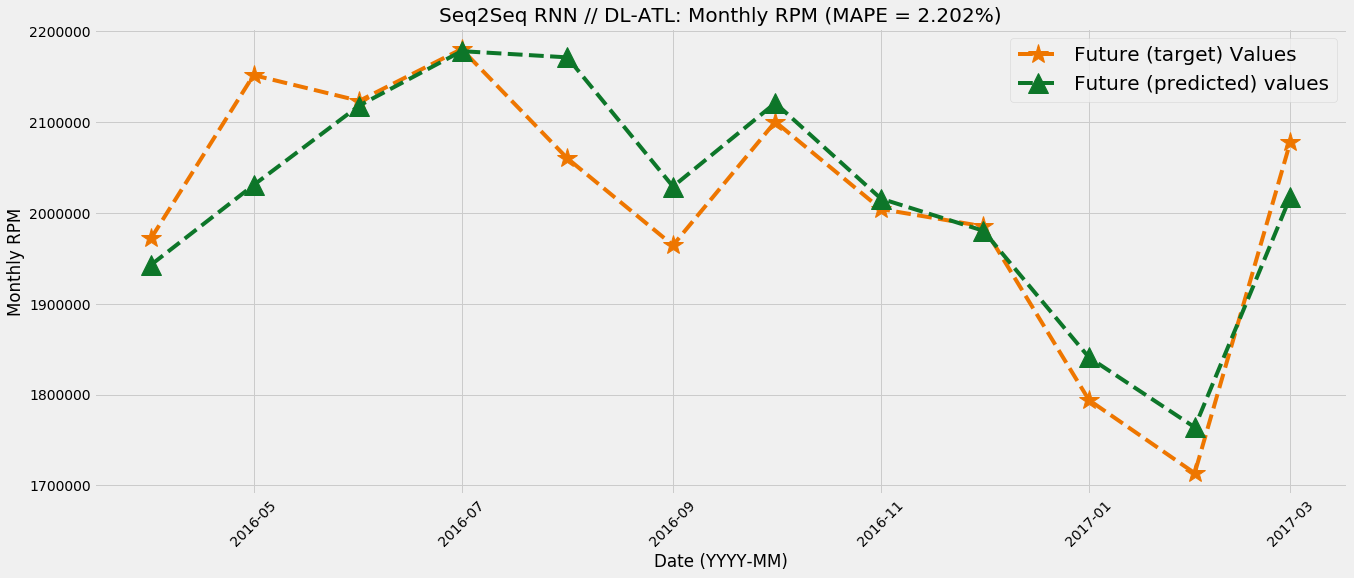

(12, 1, 1)
(12, 1, 1)


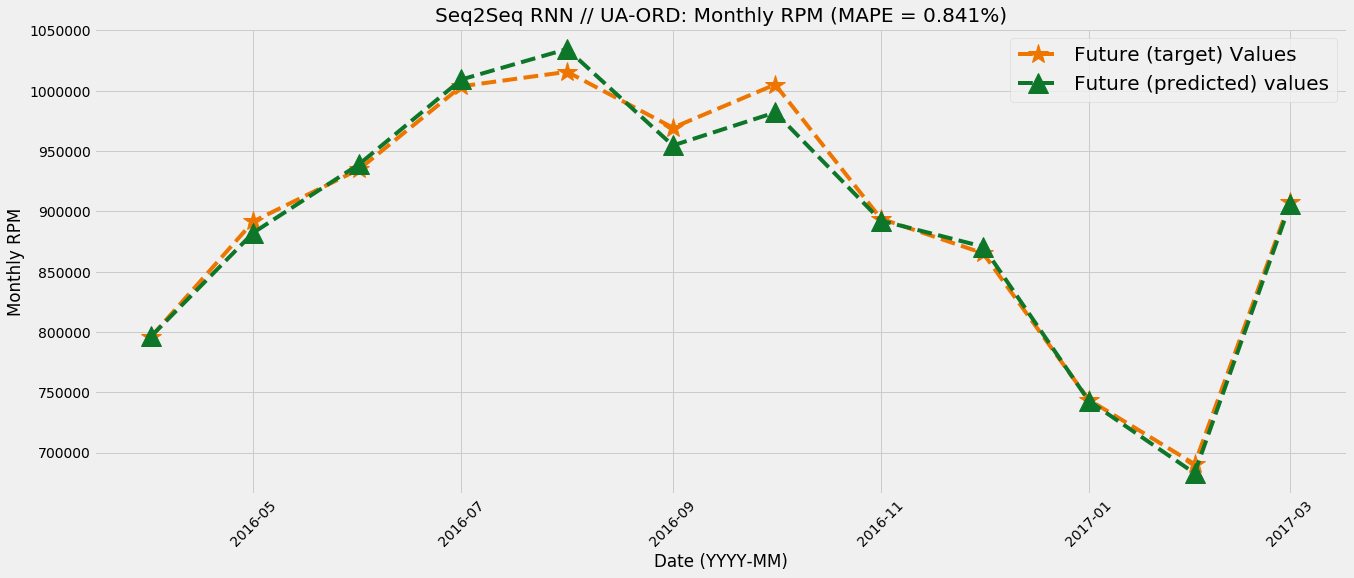

In [184]:
# Display RPM forecasts and MAPE scores for three key combinations
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
for combo in airline_airports:
    airline, airport = combo
    test_series(ts_model = ts_model,df=rpm_df, airline=airline, airport=airport, output_seq_len=output_seq_len)

In [0]:
X_train, y_train = train_samples(df = rpm_df, output_seq_len=output_seq_len, excluded= excluded)
X_train = np.transpose(X_train,(1,0,2))

In [201]:
len(X_train)

80